In [3]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np

# Customized cross validation with rolling window and XGboost
def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
    """Generate cross-validated estimates for each input data point
    
    Parameters
    ----------
    estimator : tuple
        A tuple containing two estimators. The first estimator should be the ARIMA model
        and the second one should be the Random Forest model.

    y : array-like or iterable, shape=(n_samples,)
        The time-series array.

    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables.

    cv : BaseTSCrossValidator or None, optional (default=None)
        An instance of cross-validation. If None, will use a RollingForecastCV.
        Note that for cross-validation predictions, the CV step cannot exceed
        the CV horizon, or there will be a gap between fold predictions.

    verbose : integer, optional
        The verbosity level.

    averaging : str or callable, one of ["median", "mean"] (default="mean")
        Unlike normal CV, time series CV might have different folds (windows)
        forecasting the same time step. After all forecast windows are made,
        we build a matrix of y x n_folds, populating each fold's forecasts like
        so::

            nan nan nan  # training samples
            nan nan nan
            nan nan nan
            nan nan nan
              1 nan nan  # test samples
              4   3 nan
              3 2.5 3.5
            nan   6   5
            nan nan   4

        We then average each time step's forecasts to end up with our final
        prediction results.

    return_raw_predictions : bool (default=False)
        If True, raw predictions are returned instead of averaged ones.
        This results in a y x h matrix. For example, if h=3, and step=1 then:

            nan nan nan # training samples
            nan nan nan
            nan nan nan
            nan nan nan
            1   4   2   # test samples
            2   5   7
            8   9   1
            nan nan nan
            nan nan nan

        First column contains all one-step-ahead-predictions, second column all
        two-step-ahead-predictions etc. Further metrics can then be calculated
        as desired.

    Returns
    -------
    predictions : array-like, shape=(n_samples,)
        The predicted values.

    """

    def indexable(*iterables):
        """Internal utility to handle input types"""
        results = []
        for iterable in iterables:
            if not hasattr(iterable, "__iter__"):
                raise ValueError("Input {!r} is not indexable".format(iterable))
            results.append(iterable)
        return results

    def check_cv(cv, initial = 2555):
        """Internal utility to check cv"""
        if cv is None:
            cv = RollingForecastCV(initial=initial, step=1, h=1)
        return cv

    def check_endog(y, copy=True, preserve_series=False):
        """Internal utility to check endogenous variable"""
        from pmdarima.utils import check_endog
        return check_endog(y, copy=copy, preserve_series=preserve_series)

    def _check_averaging(averaging):
        """Internal utility to check averaging"""
        if averaging == "mean":
            return np.nanmean
        elif averaging == "median":
            return np.nanmedian
        elif callable(averaging):
            return averaging
        else:
            raise ValueError("Unknown averaging method: {}".format(averaging))

    def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
        """Internal utility to fit and predict"""
        arima_model, boosted_model = estimator_tuple
        # Fit ARIMA model
        arima_model.fit(y[train]) # X=X.iloc[train, :]
        # Predict with ARIMA model
        arima_pred = arima_model.predict(n_periods=len(test))
        arima_pred_cap = max(min(1, arima_pred[0]), 0)
        # Calculate residuals for RF input
        arima_residuals_train = arima_pred - y[train]

        #model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster = 'gbtree', max_depth=5, steps =20, learning_rate=0.1) # 'reg:squarederror'
        # Train the model
        #model = model.fit(D_train, steps, watchlist)
        boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
        # Predict the labels of the test set
        #preds = model.predict(D_test)
        preds = boosted_model.predict(X.iloc[test,1:])
        # Overall prediction residuals = pred - true <=> true = pred - residuals
        overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]

        return overall_pred, test, arima_pred_cap, boosted_model.feature_importances_ #arima_residuals_test

    y, X = indexable(y, X)
    y = check_endog(y, copy=False, preserve_series=True)
    cv = check_cv(cv, initial)
    avgfunc = _check_averaging(averaging)

    if cv.step > cv.horizon:
        raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

    prediction_blocks = [
        _fit_and_predict(fold,
                         estimator,
                         y,
                         X,
                         train=train,
                         test=test,
                         verbose=verbose,)  # TODO: fit params?
        for fold, (train, test) in enumerate(cv.split(y, X))]

    pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
    arima_pred = []
    feature_importances = np.zeros((211,))
    for i, (pred_block, test_indices, arima_block, feature_importance) in enumerate(prediction_blocks):
        pred_matrix[test_indices, i] = pred_block
        arima_pred.append(arima_block)
        feature_importances += feature_importance


    if return_raw_predictions:
        predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
        for pred_block, test_indices in prediction_blocks:
            predictions[test_indices[0]] = pred_block
        return predictions

    test_mask = ~(np.isnan(pred_matrix).all(axis=1))
    predictions = pred_matrix[test_mask]



    # Calculate CV score
    cv_scores = []
    cv_scores_arima = []
    for fold, (train, test) in enumerate(cv.split(y, X)):
        fold_predictions = pred_matrix[test, fold]
        fold_score = float(abs(y[test] - fold_predictions))
        fold_arima_score = float(abs(y[test] - arima_pred[fold]))
        cv_scores.append(fold_score)
        cv_scores_arima.append(fold_arima_score)

    # Compute overall CV score
    full_score = np.mean(cv_scores)
    arima_score = np.mean(cv_scores_arima)

    return avgfunc(predictions, axis=1), np.array(arima_pred), full_score,  arima_score, cv_scores, cv_scores_arima, feature_importances


In [8]:
import sys
import pandas as pd
import pmdarima as pm
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_SARIMA_Boosted(strækning = 1, station = 0, model_no = 0, no_preds=30): #sys.argv[1] sys.argv[2]
    # Extract data
    data = pd.read_csv("Data/Cleaned_data.csv")
    y = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed'].values
    X = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].iloc[:,1:]

    # Best model parameters for ARIMA
    model_params_arima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
    best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(strækning), int(station)))]['Values'][0])

    # Define models
    arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
    if model_no: # 0=Xgboost, 1=Catboost
        boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 

    # Expanding Window CV
    initial_start = y.shape[0] - no_preds
    pred_full, pred_arima, error_full, error_arima, cv_score_full, cv_score_arima, feature_importances = custom_cross_val_predict((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
    result_dictionary = {'Predictions_full': pred_full, 'Predictions_arima': pred_arima, 'Error_full': error_full, 'Error_arima': error_arima, 'CV_score_full': cv_score_full, 
                  'CV_score_arima': cv_score_arima}
    
    # Save results in .csv's
    result_df = pd.DataFrame(result_dictionary)
    fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
    result_df.to_csv(f'Results/({strækning}, {station})_SARIMA_Boosted{model_no}_results.csv', index=False)
    fi_df.to_csv(f'Results/({strækning}, {station})_SARIMA_Boosted{model_no}_feature_importances.csv', index=False)

In [9]:
HPC_SARIMA_Boosted(strækning = 1, station = 0, model_no=1)

# Final

In [ ]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np

# Customized cross validation with rolling window and XGboost
def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
    """Generate cross-validated estimates for each input data point
    
    Parameters
    ----------
    estimator : tuple
        A tuple containing two estimators. The first estimator should be the ARIMA model
        and the second one should be the Random Forest model.

    y : array-like or iterable, shape=(n_samples,)
        The time-series array.

    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables.

    cv : BaseTSCrossValidator or None, optional (default=None)
        An instance of cross-validation. If None, will use a RollingForecastCV.
        Note that for cross-validation predictions, the CV step cannot exceed
        the CV horizon, or there will be a gap between fold predictions.

    verbose : integer, optional
        The verbosity level.

    averaging : str or callable, one of ["median", "mean"] (default="mean")
        Unlike normal CV, time series CV might have different folds (windows)
        forecasting the same time step. After all forecast windows are made,
        we build a matrix of y x n_folds, populating each fold's forecasts like
        so::

            nan nan nan  # training samples
            nan nan nan
            nan nan nan
            nan nan nan
              1 nan nan  # test samples
              4   3 nan
              3 2.5 3.5
            nan   6   5
            nan nan   4

        We then average each time step's forecasts to end up with our final
        prediction results.

    return_raw_predictions : bool (default=False)
        If True, raw predictions are returned instead of averaged ones.
        This results in a y x h matrix. For example, if h=3, and step=1 then:

            nan nan nan # training samples
            nan nan nan
            nan nan nan
            nan nan nan
            1   4   2   # test samples
            2   5   7
            8   9   1
            nan nan nan
            nan nan nan

        First column contains all one-step-ahead-predictions, second column all
        two-step-ahead-predictions etc. Further metrics can then be calculated
        as desired.

    Returns
    -------
    predictions : array-like, shape=(n_samples,)
        The predicted values.

    """

    def indexable(*iterables):
        """Internal utility to handle input types"""
        results = []
        for iterable in iterables:
            if not hasattr(iterable, "__iter__"):
                raise ValueError("Input {!r} is not indexable".format(iterable))
            results.append(iterable)
        return results

    def check_cv(cv, initial = 2555):
        """Internal utility to check cv"""
        if cv is None:
            cv = RollingForecastCV(initial=initial, step=1, h=1)
        return cv

    def check_endog(y, copy=True, preserve_series=False):
        """Internal utility to check endogenous variable"""
        from pmdarima.utils import check_endog
        return check_endog(y, copy=copy, preserve_series=preserve_series)

    def _check_averaging(averaging):
        """Internal utility to check averaging"""
        if averaging == "mean":
            return np.nanmean
        elif averaging == "median":
            return np.nanmedian
        elif callable(averaging):
            return averaging
        else:
            raise ValueError("Unknown averaging method: {}".format(averaging))

    def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
        """Internal utility to fit and predict"""
        arima_model, boosted_model = estimator_tuple
        # Fit ARIMA model
        arima_model.fit(y[train]) # X=X.iloc[train, :]
        # Predict with ARIMA model
        arima_pred = arima_model.predict(n_periods=len(test))
        arima_pred_cap = max(min(1, arima_pred[0]), 0)
        # Calculate residuals for RF input
        arima_residuals_train = arima_pred - y[train]

        #model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster = 'gbtree', max_depth=5, steps =20, learning_rate=0.1) # 'reg:squarederror'
        # Train the model
        #model = model.fit(D_train, steps, watchlist)
        boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
        # Predict the labels of the test set
        #preds = model.predict(D_test)
        preds = boosted_model.predict(X.iloc[test,1:])
        # Overall prediction residuals = pred - true <=> true = pred - residuals
        overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]

        return overall_pred, test, arima_pred_cap, boosted_model.feature_importances_ #arima_residuals_test

    y, X = indexable(y, X)
    y = check_endog(y, copy=False, preserve_series=True)
    cv = check_cv(cv, initial)
    avgfunc = _check_averaging(averaging)

    if cv.step > cv.horizon:
        raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

    prediction_blocks = [
        _fit_and_predict(fold,
                         estimator,
                         y,
                         X,
                         train=train,
                         test=test,
                         verbose=verbose,)  # TODO: fit params?
        for fold, (train, test) in enumerate(cv.split(y, X))]

    pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
    arima_pred = []
    feature_importances = np.zeros((211,))
    for i, (pred_block, test_indices, arima_block, feature_importance) in enumerate(prediction_blocks):
        pred_matrix[test_indices, i] = pred_block
        arima_pred.append(arima_block)
        feature_importances += feature_importance


    if return_raw_predictions:
        predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
        for pred_block, test_indices in prediction_blocks:
            predictions[test_indices[0]] = pred_block
        return predictions

    test_mask = ~(np.isnan(pred_matrix).all(axis=1))
    predictions = pred_matrix[test_mask]



    # Calculate CV score
    cv_scores = []
    cv_scores_arima = []
    for fold, (train, test) in enumerate(cv.split(y, X)):
        fold_predictions = pred_matrix[test, fold]
        fold_score = float(abs(y[test] - fold_predictions))
        fold_arima_score = float(abs(y[test] - arima_pred[fold]))
        cv_scores.append(fold_score)
        cv_scores_arima.append(fold_arima_score)

    # Compute overall CV score
    full_score = np.mean(cv_scores)
    arima_score = np.mean(cv_scores_arima)

    return avgfunc(predictions, axis=1), np.array(arima_pred), full_score,  arima_score, cv_scores, cv_scores_arima, feature_importances

import sys
import pandas as pd
import pmdarima as pm
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_SARIMA_Boosted(strækning = sys.argv[1], station = sys.argv[2], model_no = sys.argv[3], no_preds=sys.argv[4]): #sys.argv[1] sys.argv[2]
    # Extract data
    data = pd.read_csv("Data/Cleaned_data.csv")
    y = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)]['togpunktlighed'].values
    X = data[(data['visualiseringskode'] == strækning) & (data['station'] == station)].iloc[:,1:]

    # Best model parameters for ARIMA
    model_params_arima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
    best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(strækning), int(station)))]['Values'][0])

    # Define models
    arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
    if model_no: # 0=Xgboost, 1=Catboost
        boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 

    # Expanding Window CV
    initial_start = y.shape[0] - no_preds
    pred_full, pred_arima, error_full, error_arima, cv_score_full, cv_score_arima, feature_importances = custom_cross_val_predict((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
    result_dictionary = {'Predictions_full': pred_full, 'Predictions_arima': pred_arima, 'Error_full': error_full, 'Error_arima': error_arima, 'CV_score_full': cv_score_full, 
                  'CV_score_arima': cv_score_arima}
    
    # Save results in .csv's
    result_df = pd.DataFrame(result_dictionary)
    fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
    result_df.to_csv(f'Results/({strækning}, {station})_SARIMA_Boosted{model_no}_results.csv', index=False)
    fi_df.to_csv(f'Results/({strækning}, {station})_SARIMA_Boosted{model_no}_feature_importances.csv', index=False)

In [12]:
import glob,subprocess
import numpy as np  # Ensure numpy is imported
combinations = [[1,0], [1,1], [2,0]]
cmd = '''hi
safa'''
for straekning, station in combinations:
    cmdi = cmd + f' {straekning} {station} 0 30'
    proc = subprocess.Popen('bsub ', stdin=subprocess.PIPE, shell=True)
    proc.communicate(bytes(cmdi, encoding='UTF-8'))

/bin/sh: bsub: command not found
/bin/sh: bsub: command not found
/bin/sh: bsub: command not found


In [2]:
import ast
ast.literal_eval('[(3, 1, 5), (0, 0, 0, 0)]')[0]

(3, 1, 5)

# True Final (ARIMA + Boosted)

In [ ]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import sys
import pandas as pd
import pmdarima as pm
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_SARIMA_Boosted(straekning = sys.argv[1], station = sys.argv[2], model_no = sys.argv[3], no_preds=sys.argv[4]): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
		"""Generate cross-validated estimates for each input data point
		
		Parameters
		----------
		estimator : tuple
			A tuple containing two estimators. The first estimator should be the ARIMA model
			and the second one should be the Random Forest model.

		y : array-like or iterable, shape=(n_samples,)
			The time-series array.

		X : array-like, shape=[n_obs, n_vars], optional (default=None)
			An optional 2-d array of exogenous variables.

		cv : BaseTSCrossValidator or None, optional (default=None)
			An instance of cross-validation. If None, will use a RollingForecastCV.
			Note that for cross-validation predictions, the CV step cannot exceed
			the CV horizon, or there will be a gap between fold predictions.

		verbose : integer, optional
			The verbosity level.

		averaging : str or callable, one of ["median", "mean"] (default="mean")
			Unlike normal CV, time series CV might have different folds (windows)
			forecasting the same time step. After all forecast windows are made,
			we build a matrix of y x n_folds, populating each fold's forecasts like
			so::

				nan nan nan  # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				  1 nan nan  # test samples
				  4   3 nan
				  3 2.5 3.5
				nan   6   5
				nan nan   4

			We then average each time step's forecasts to end up with our final
			prediction results.

		return_raw_predictions : bool (default=False)
			If True, raw predictions are returned instead of averaged ones.
			This results in a y x h matrix. For example, if h=3, and step=1 then:

				nan nan nan # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				1   4   2   # test samples
				2   5   7
				8   9   1
				nan nan nan
				nan nan nan

			First column contains all one-step-ahead-predictions, second column all
			two-step-ahead-predictions etc. Further metrics can then be calculated
			as desired.

		Returns
		-------
		predictions : array-like, shape=(n_samples,)
			The predicted values.

		"""

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=1)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = max(min(1, arima_pred[0]), 0)
			# Calculate residuals for RF input
			arima_residuals_train = arima_pred - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		y_true = []
		feature_importances = np.zeros((211,))
		for i, (pred_block, test_indices, arima_block, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances += feature_importance
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		cv_scores = []
		cv_scores_arima = []
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_score = float(abs(y[test] - fold_predictions))
			fold_arima_score = float(abs(y[test] - arima_pred[fold]))
			cv_scores.append(fold_score)
			cv_scores_arima.append(fold_arima_score)

		# Compute overall CV score
		full_score = np.mean(cv_scores)
		arima_score = np.mean(cv_scores_arima)

		return y_true, avgfunc(predictions, axis=1), np.array(arima_pred), full_score,  arima_score, cv_scores, cv_scores_arima, feature_importances

	# Extract data
	data = pd.read_csv("Data/Cleaned_data.csv")
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Best model parameters for ARIMA
	model_params_arima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
	best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])

	# Define models
	arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  

	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds
	y_true, pred_full, pred_arima, error_full, error_arima, cv_score_full, cv_score_arima, feature_importances = custom_cross_val_predict((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
	result_dictionary = {'y_true': y_true,'Predictions_full': pred_full, 'Predictions_arima': pred_arima, 'Error_full': error_full, 'Error_arima': error_arima, 'CV_score_full': cv_score_full, 
				  'CV_score_arima': cv_score_arima}

	# Save results in .csv's
	result_df = pd.DataFrame(result_dictionary)
	fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
	result_df.to_csv('Results/Separate_Runs/({}, {})_SARIMA_Boosted{}_results{}.csv'.format(straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/({}, {})_SARIMA_Boosted{}_feature_importances{}.csv'.format(straekning, station, model_no, no_preds), index=False)

HPC_SARIMA_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]))

In [ ]:
# Caller
cmd = '''
#!/bin/sh
#BSUB -J DSB_SARIMA_submit
#BSUB -o DSB_SARIMA_submit%J.out
#BSUB -e DSB_SARIMA_submit%J.err
#BSUB -n 4
#BSUB -R "rusage[mem=10G]"
#BSUB -R "span[hosts=1]"
#BSUB -W 2:00 
##BSUB -u s214659@dtu.dk
### -- send notification at start --
#BSUB -B
### -- send notification at completion--
#BSUB -N
#BSUB -o Output_%J.out 
#BSUB -e Error_%J.err 
# end of BSUB options

# load a scipy module
# replace VERSION and uncomment
# module load scipy
module load python3/3.10.13
# activate the virtual environment 
# NOTE: needs to have been built with the same SciPy version above!
source DSB_env/bin/activate
### python tester.py
python Individual_SARIMA_Boosted_CV1.py'''
import glob,subprocess
import numpy as np  # Ensure numpy is imported
combinations = [[1,0], [1,1], [2,0]]

for straekning, station in combinations:
    cmdi = cmd + ' {} {} {} {}'.format(straekning,station,0,30)
    #print(cmdi)
    proc = subprocess.Popen('bsub ', stdin=subprocess.PIPE, shell=True)
    #proc.communicate(bytes(cmdi, encoding='UTF-8'))
    proc.communicate(cmdi.encode('UTF-8'))


# True final (Boosted)

In [25]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import sys
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
		"""Generate cross-validated estimates for each input data point
		
		Parameters
		----------
		estimator : tuple
			A tuple containing two estimators. The first estimator should be the ARIMA model
			and the second one should be the Random Forest model.

		y : array-like or iterable, shape=(n_samples,)
			The time-series array.

		X : array-like, shape=[n_obs, n_vars], optional (default=None)
			An optional 2-d array of exogenous variables.

		cv : BaseTSCrossValidator or None, optional (default=None)
			An instance of cross-validation. If None, will use a RollingForecastCV.
			Note that for cross-validation predictions, the CV step cannot exceed
			the CV horizon, or there will be a gap between fold predictions.

		verbose : integer, optional
			The verbosity level.

		averaging : str or callable, one of ["median", "mean"] (default="mean")
			Unlike normal CV, time series CV might have different folds (windows)
			forecasting the same time step. After all forecast windows are made,
			we build a matrix of y x n_folds, populating each fold's forecasts like
			so::

				nan nan nan  # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				  1 nan nan  # test samples
				  4   3 nan
				  3 2.5 3.5
				nan   6   5
				nan nan   4

			We then average each time step's forecasts to end up with our final
			prediction results.

		return_raw_predictions : bool (default=False)
			If True, raw predictions are returned instead of averaged ones.
			This results in a y x h matrix. For example, if h=3, and step=1 then:

				nan nan nan # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				1   4   2   # test samples
				2   5   7
				8   9   1
				nan nan nan
				nan nan nan

			First column contains all one-step-ahead-predictions, second column all
			two-step-ahead-predictions etc. Further metrics can then be calculated
			as desired.

		Returns
		-------
		predictions : array-like, shape=(n_samples,)
			The predicted values.

		"""

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=1)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.array(max(min(1, preds), 0)) # make sure it is in [0;1]
			return overall_pred, test, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		feature_importances = np.zeros((211,))
		for i, (pred_block, test_indices, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances += feature_importance
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		cv_scores = []
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_score = float(abs(y[test] - fold_predictions))
			cv_scores.append(fold_score)
			
		# Compute overall CV score
		full_score = np.mean(cv_scores)

		return y_true, avgfunc(predictions, axis=1), full_score,  cv_scores, feature_importances

	# Extract data
	data = pd.read_csv("Data/Cleaned_data.csv")
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  

	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds
	y_true, pred_full, error_full, cv_score_full, feature_importances = custom_cross_val_predict((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
	result_dictionary = {'y_true': y_true,'Predictions_full': pred_full, 'Error_full': error_full, 'CV_score_full': cv_score_full}

	# Save results in .csv's
	result_df = pd.DataFrame(result_dictionary)
	fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
	result_df.to_csv('Results/Separate_Runs/Xgboost/({}, {})_Boosted{}_results{}.csv'.format(straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/Xgboost/({}, {})_Boosted{}_feature_importances{}.csv'.format(straekning, station, model_no, no_preds), index=False)

#HPC_SARIMA_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]))
HPC_Boosted(straekning = 2, station = 0, model_no = 0, no_preds=10)

Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


# True Final (HMM + Boosted)

In [24]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import sys
import pandas as pd
from hmmlearn import hmm
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_SARIMA_Boosted(straekning, station, model_no, no_preds): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):
		"""Generate cross-validated estimates for each input data point
		
		Parameters
		----------
		estimator : tuple
			A tuple containing two estimators. The first estimator should be the ARIMA model
			and the second one should be the Random Forest model.

		y : array-like or iterable, shape=(n_samples,)
			The time-series array.

		X : array-like, shape=[n_obs, n_vars], optional (default=None)
			An optional 2-d array of exogenous variables.

		cv : BaseTSCrossValidator or None, optional (default=None)
			An instance of cross-validation. If None, will use a RollingForecastCV.
			Note that for cross-validation predictions, the CV step cannot exceed
			the CV horizon, or there will be a gap between fold predictions.

		verbose : integer, optional
			The verbosity level.

		averaging : str or callable, one of ["median", "mean"] (default="mean")
			Unlike normal CV, time series CV might have different folds (windows)
			forecasting the same time step. After all forecast windows are made,
			we build a matrix of y x n_folds, populating each fold's forecasts like
			so::

				nan nan nan  # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				  1 nan nan  # test samples
				  4   3 nan
				  3 2.5 3.5
				nan   6   5
				nan nan   4

			We then average each time step's forecasts to end up with our final
			prediction results.

		return_raw_predictions : bool (default=False)
			If True, raw predictions are returned instead of averaged ones.
			This results in a y x h matrix. For example, if h=3, and step=1 then:

				nan nan nan # training samples
				nan nan nan
				nan nan nan
				nan nan nan
				1   4   2   # test samples
				2   5   7
				8   9   1
				nan nan nan
				nan nan nan

			First column contains all one-step-ahead-predictions, second column all
			two-step-ahead-predictions etc. Further metrics can then be calculated
			as desired.

		Returns
		-------
		predictions : array-like, shape=(n_samples,)
			The predicted values.

		"""

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=1)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			hmm_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			hmm_model.fit(y[train].reshape(-1,1)) # X=X.iloc[train, :]
			# Predict with HMM model
			### NOTE: ONLY ONE STEP - NEEDS LOOP If more
			last_state = hmm_model.predict(y[train].reshape(-1,1))[-1]
			# State transition matrix
			next_state_probs = hmm_model.transmat_[last_state]
			next_state = np.argmax(next_state_probs)
            # Mean and variance of next state
			mean_next_state = hmm_model.means_[next_state]
			covar_next_state = hmm_model.covars_[next_state]
			#hmm_pred = np.random.multivariate_normal(mean_next_state.ravel(), covar_next_state)
			hmm_pred = [np.mean([mean_next_state, y[train].reshape(-1,1)[-1]])] # The mean and the latest value -> smaller error.
			
			hmm_pred_cap = max(min(1, hmm_pred[0]), 0)
			# Calculate residuals for RF input
			hmm_residuals_train = hmm_pred - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], hmm_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.array(max(min(1, hmm_pred[0] - preds), 0)) # make sure it is in [0;1]
			return overall_pred, test, hmm_pred_cap, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		hmm_pred = []
		y_true = []
		feature_importances = np.zeros((211,))
		for i, (pred_block, test_indices, hmm_block, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			hmm_pred.append(hmm_block)
			feature_importances += feature_importance
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		cv_scores = []
		cv_scores_hmm = []
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_score = float(abs(y[test] - fold_predictions))
			fold_hmm_score = float(abs(y[test] - hmm_pred[fold]))
			cv_scores.append(fold_score)
			cv_scores_hmm.append(fold_hmm_score)

		# Compute overall CV score
		full_score = np.mean(cv_scores)
		hmm_score = np.mean(cv_scores_hmm)

		return y_true, avgfunc(predictions, axis=1), np.array(hmm_pred), full_score,  hmm_score, cv_scores, cv_scores_hmm, feature_importances

	# Extract data
	data = pd.read_csv("Data/Cleaned_data.csv")
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	np.random.seed(22)
	hmm_model = hmm.GaussianHMM(n_components=10, covariance_type="full", algorithm='viterbi')
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  

	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds
	y_true, pred_full, pred_hmm, error_full, error_hmm, cv_score_full, cv_score_hmm, feature_importances = custom_cross_val_predict((hmm_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
	result_dictionary = {'y_true': y_true,'Predictions_full': pred_full, 'Predictions_hmm': pred_hmm, 'Error_full': error_full, 'Error_hmm': error_hmm, 'CV_score_full': cv_score_full, 
				  'CV_score_hmm': cv_score_hmm}

	# Save results in .csv's
	result_df = pd.DataFrame(result_dictionary)
	fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
	result_df.to_csv('Results/Separate_Runs/({}, {})_HMM_Boosted{}_results{}.csv'.format(straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/({}, {})_HMM_Boosted{}_feature_importances{}.csv'.format(straekning, station, model_no, no_preds), index=False)

#HPC_SARIMA_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]))
HPC_SARIMA_Boosted(straekning = 2, station = 0, model_no = 0, no_preds=10)

Initialize Expanding Window CV
Fold 0


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 1


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 2


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 3


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 4


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 5


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 6


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 7


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 8


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Fold 9


# All options in one!

In [38]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import sys
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=1)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = np.mean(y[train])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.array(max(min(1, preds), 0)) # make sure it is in [0;1]
			return overall_pred, test, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros(prediction_blocks[0][3].shape)
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances += feature_importance
			y_true += [y[test_indices][0]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		cv_scores = []
		cv_scores_baseline = []
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_score = float(abs(y[test] - fold_predictions))
			cv_scores.append(fold_score)
			cv_scores_baseline.append(float(abs(y[test] - baseline_pred[fold])))
			
		# Compute overall CV score
		full_score = np.mean(cv_scores)
		baseline_score = np.mean(cv_scores_baseline)

		result_dictionary = {'y_true': y_true,'Predictions_full': avgfunc(predictions, axis=1), 'Predictions_baseline': baseline_pred, 'Error_full': full_score, 'Error_baseline': baseline_score, 'CV_score_full': cv_scores, 'CV_score_baseline': cv_scores_baseline}

		# Save results in .csv's
		result_df = pd.DataFrame(result_dictionary)
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=1)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = np.mean(y[train])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = max(min(1, arima_pred[0]), 0)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.array(max(min(1, arima_pred[0] - preds), 0)) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros(prediction_blocks[0][4].shape)
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances += feature_importance
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]

		# Calculate CV score
		cv_scores = []
		cv_scores_arima = []
		cv_scores_baseline =[]
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_score = float(abs(y[test] - fold_predictions))
			fold_arima_score = float(abs(y[test] - arima_pred[fold]))
			cv_scores.append(fold_score)
			cv_scores_arima.append(fold_arima_score)
			cv_scores_baseline.append(float(abs(y[test] - baseline_pred[fold])))

		# Compute overall CV score
		full_score = np.mean(cv_scores)
		arima_score = np.mean(cv_scores_arima)
		baseline_score = np.mean(cv_scores_baseline)
		result_dictionary = {'y_true': y_true,'Predictions_full': avgfunc(predictions, axis=1), 'Predictions_arima': np.array(arima_pred), 'Predictions_baseline': baseline_pred, 'Error_full': full_score, 'Error_arima': arima_score, 'Error_baseline': baseline_score, 'CV_score_full': cv_scores, 'CV_score_arima': cv_scores_arima, 'CV_score_baseline':cv_scores_baseline}
		# Save results in .csv's
		result_df = pd.DataFrame(result_dictionary)
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	model_name = 'Xgboost'
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	print(f'Running... \nBoth ARIMA and Boosted Random Forest: {both} \nBoosted Random Forest Model: {model_name} \nDataset: {data_name}\nNo. predictions: {no_preds}')
	print('----------------')
	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds

	if both:
		print('HI')
		model_name = 'SARIMA_' + model_name
		model_params_arima = pd.read_csv('Data/Best_model_parameters_SARIMA_strækning_station.csv')
		best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
		# Define models
		arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
		result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
	else:
		print('HO')
		result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start)
	print(result_df, fi_df)
	result_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_{}{}_results{}.csv'.format(data_name, model_name, straekning, station, model_name, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_{}{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_name, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]))
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=10, data_name='Cleaned_simple_lagged', both=False)


Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_simple_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
HO
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
   y_true  Predictions_full  Predictions_baseline  Error_full  Error_baseline  \
0   0.834          0.755976              0.822660    0.079303        0.078479   
1   0.760          0.778434              0.822665    0.079303        0.078479   
2   0.921          0.820290              0.822640    0.079303        0.078479   
3   0.926          0.853453              0.822679    0.079303        0.078479   
4   0.941          0.855831              0.822719    0.079303        0.078479   
5   0.674          0.843515              0.822766    0.079303        0.078479   
6   0.849          0.798759              0.822707    0.079303        0.078479   
7   0.888          0.823909              0.822718    0.079303        0.078479   
8  

# All in one with x predictions into the future

In [37]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]
			return overall_pred, test, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros(prediction_blocks[0][3].shape)
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances += feature_importance
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, boosted_model.feature_importances_ #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros(prediction_blocks[0][4].shape)
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances += feature_importance
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'Predictions_ARIMA{i}'] = arima_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
				fold_dict[f'CV_score_ARIMA{i}'] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]
			result_df[f'Error_ARIMA{i}'] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances'])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	model_name = 'XGBoost'
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	print(f'Running... \nBoth ARIMA and Boosted Random Forest: {both} \nBoosted Random Forest Model: {model_name} \nDataset: {data_name}\nNo. predictions: {no_preds}')
	print('----------------')
	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds

	if both:
		model_name = 'ARIMA_' + model_name
		model_params_arima = pd.read_csv('Data/Best_model_parameters_ARIMA_route_station.csv')
		best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
		# Define models
		arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
		result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
		
	else:
		result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
	
	result_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=sys.argv[6], horizon=1)
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=365, data_name='Cleaned_simple_lagged', both=True, horizon=1)

Running... 
Both ARIMA and Boosted Random Forest: True 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_simple_lagged
No. predictions: 365
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fold 11
Fold 12
Fold 13
Fold 14
Fold 15
Fold 16
Fold 17
Fold 18
Fold 19
Fold 20
Fold 21
Fold 22
Fold 23
Fold 24
Fold 25
Fold 26
Fold 27
Fold 28
Fold 29
Fold 30
Fold 31
Fold 32
Fold 33
Fold 34
Fold 35
Fold 36
Fold 37
Fold 38
Fold 39
Fold 40
Fold 41
Fold 42
Fold 43
Fold 44
Fold 45
Fold 46
Fold 47
Fold 48
Fold 49
Fold 50
Fold 51
Fold 52
Fold 53
Fold 54
Fold 55
Fold 56
Fold 57
Fold 58
Fold 59
Fold 60
Fold 61
Fold 62
Fold 63
Fold 64
Fold 65
Fold 66
Fold 67
Fold 68
Fold 69
Fold 70
Fold 71
Fold 72
Fold 73
Fold 74
Fold 75
Fold 76
Fold 77
Fold 78
Fold 79
Fold 80
Fold 81
Fold 82
Fold 83
Fold 84
Fold 85
Fold 86
Fold 87
Fold 88
Fold 89
Fold 90
Fold 91
Fold 92
Fold 93
Fold 94
Fold 95
Fold 96
Fold 97
Fold 98
Fold 99
Fold 100
Fold 1

# All in one with x predictions and Shap values

In [2]:
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import shap
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]
			return overall_pred, test, baseline, explanation.values #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros((prediction_blocks[0][3].shape[1], no_preds))
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=[f'Feature_importances{i}' for i in range(feature_importances.shape[1])])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, explanation.values #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros(prediction_blocks[0][4].shape)
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances += feature_importance
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold][i])
				fold_dict[f'y_true{i}'] = y[test][i]
				fold_dict[f'Predictions_full{i}'] = fold_predictions[i]
				fold_dict[f'Predictions_baseline{i}'] = baseline_pred[fold][i]
				fold_dict[f'Predictions_ARIMA{i}'] = arima_pred[fold][i]
				fold_dict[f'CV_score_full{i}'] = fold_score
				fold_dict[f'CV_score_baseline{i}'] = fold_score_baseline
				fold_dict[f'CV_score_ARIMA{i}'] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(horizon):
			result_df[f'Error_full{i}'] = full_score[i]
			result_df[f'Error_baseline{i}'] = baseline_score[i]
			result_df[f'Error_ARIMA{i}'] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances[0], columns=['Feature_importances'])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	model_name = 'XGBoost'
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	print(f'Running... \nBoth ARIMA and Boosted Random Forest: {both} \nBoosted Random Forest Model: {model_name} \nDataset: {data_name}\nNo. predictions: {no_preds}')
	print('----------------')
	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds

	if both:
		model_name = 'ARIMA_' + model_name
		model_params_arima = pd.read_csv('Data/Best_model_p arameters_ARIMA_route_station.csv')
		best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
		# Define models
		arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
		result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
		
	else:
		result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
	
	result_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=sys.argv[6], horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=365, data_name='Cleaned_simple_lagged', both=False, horizon=1)

Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_simple_lagged
No. predictions: 365
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fold 11
Fold 12
Fold 13
Fold 14
Fold 15
Fold 16
Fold 17
Fold 18
Fold 19
Fold 20
Fold 21
Fold 22
Fold 23
Fold 24
Fold 25
Fold 26
Fold 27
Fold 28
Fold 29
Fold 30
Fold 31
Fold 32
Fold 33
Fold 34
Fold 35
Fold 36
Fold 37
Fold 38
Fold 39
Fold 40
Fold 41
Fold 42
Fold 43
Fold 44
Fold 45
Fold 46
Fold 47
Fold 48
Fold 49
Fold 50
Fold 51
Fold 52
Fold 53
Fold 54
Fold 55
Fold 56
Fold 57
Fold 58
Fold 59
Fold 60
Fold 61
Fold 62
Fold 63
Fold 64
Fold 65
Fold 66
Fold 67
Fold 68
Fold 69
Fold 70
Fold 71
Fold 72
Fold 73
Fold 74
Fold 75
Fold 76
Fold 77
Fold 78
Fold 79
Fold 80
Fold 81
Fold 82
Fold 83
Fold 84
Fold 85
Fold 86
Fold 87
Fold 88
Fold 89
Fold 90
Fold 91
Fold 92
Fold 93
Fold 94
Fold 95
Fold 96
Fold 97
Fold 98
Fold 99
Fold 100
Fold 

# With Matrix shap values

In [6]:
# True code for thinlinc
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import shap
import sys
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]			
			return overall_pred, test, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros((prediction_blocks[0][3].shape[0], no_preds-horizon + 1))
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(i)] = y[test][i]
				fold_dict['Predictions_full{}'.format(i)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(i)] = baseline_pred[fold][i]
				fold_dict['CV_score_full{}'.format(i)] = fold_score
				fold_dict['CV_score_baseline{}'.format(i)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(horizon):
			result_df['Error_full{}'.format(i)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}'.format(i) for i in range(feature_importances.shape[1])])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros((prediction_blocks[0][4].shape[0], no_preds - horizon + 1))
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold][i])
				fold_dict['y_true{}'.format(i)] = y[test][i]
				fold_dict['Predictions_full{}'.format(i)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(i)] = baseline_pred[fold][i]
				fold_dict['Predictions_ARIMA{}'.format(i)] = arima_pred[fold][i]
				fold_dict['CV_score_full{}'.format(i)] = fold_score
				fold_dict['CV_score_baseline{}'.format(i)] = fold_score_baseline
				fold_dict['CV_score_ARIMA{}'.format(i)] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(horizon):
			result_df['Error_full{}'.format(i)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]
			result_df['Error_ARIMA{}'.format(i)] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}'.format(i) for i in range(feature_importances.shape[1])])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]

	# Define models
	model_name = 'XGBoost'
	boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
	if model_no: # 0=Xgboost, 1=Catboost
		model_name = 'Catboost'
		boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
	print('Running... \nBoth ARIMA and Boosted Random Forest: {} \nBoosted Random Forest Model: {} \nDataset: {}\nNo. predictions: {}'.format(both, model_name, data_name, no_preds))
	print('----------------')
	# Expanding Window CV
	print('Initialize Expanding Window CV')
	initial_start = y.shape[0] - no_preds

	if both:
		model_name = 'ARIMA_' + model_name
		model_params_arima = pd.read_csv('Data/Best_model_parameters_ARIMA_route_station.csv')
		best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
		# Define models
		arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
		result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
		
	else:
		result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
	
	result_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	fi_df.to_csv('Results/Separate_Runs/{}/{}/({}, {})_Boosted{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]), horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=10, data_name='Cleaned_simple_lagged', both=True, horizon=1)

Running... 
Both ARIMA and Boosted Random Forest: True 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_simple_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8


# Shap consistency over years check

In [4]:
# True code for thinlinc
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import shap
import sys
import datetime
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], y[train])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]			
			return overall_pred, test, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros((prediction_blocks[0][3].shape[0], no_preds-horizon + 1))
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(i)] = y[test][i]
				fold_dict['Predictions_full{}'.format(i)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(i)] = baseline_pred[fold][i]
				fold_dict['CV_score_full{}'.format(i)] = fold_score
				fold_dict['CV_score_baseline{}'.format(i)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(horizon):
			result_df['Error_full{}'.format(i)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}'.format(i) for i in range(feature_importances.shape[1])])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			baseline = [np.mean(y[train])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=len(test))
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial, h=horizon)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros((prediction_blocks[0][4].shape[0], no_preds - horizon + 1))
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(horizon):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold][i])
				fold_dict['y_true{}'.format(i)] = y[test][i]
				fold_dict['Predictions_full{}'.format(i)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(i)] = baseline_pred[fold][i]
				fold_dict['Predictions_ARIMA{}'.format(i)] = arima_pred[fold][i]
				fold_dict['CV_score_full{}'.format(i)] = fold_score
				fold_dict['CV_score_baseline{}'.format(i)] = fold_score_baseline
				fold_dict['CV_score_ARIMA{}'.format(i)] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(horizon):
			result_df['Error_full{}'.format(i)] = full_score[i]
			result_df['Error_baseline{}'.format(i)] = baseline_score[i]
			result_df['Error_ARIMA{}'.format(i)] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}'.format(i) for i in range(feature_importances.shape[1])])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	start_dates = [datetime.datetime.strptime(f'01-01-20{i+16}', '%d-%m-%Y') for i in range(8)]
	periods = [(start_dates[i], start_dates[i+2]) for i in range(6)]
	for i in range(len(periods)): 
		date_condition = ((periods[i][0] <= pd.to_datetime(data['dato'])) & (pd.to_datetime(data['dato']) < periods[i][1]))
		y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station) & date_condition]['togpunktlighed'].values
		X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station) & date_condition].iloc[:,1:]

		# Define models
		model_name = 'XGBoost'
		boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
		if model_no: # 0=Xgboost, 1=Catboost
			model_name = 'Catboost'
			boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=20, learning_rate=0.1, max_depth=5, verbose=0)  
		print('Running... \nBoth ARIMA and Boosted Random Forest: {} \nBoosted Random Forest Model: {} \nDataset: {}\nNo. predictions: {}'.format(both, model_name, data_name, no_preds))
		print('----------------')
		# Expanding Window CV
		print('Initialize Expanding Window CV')
		initial_start = y.shape[0] - no_preds

		if both:
			model_name = 'ARIMA_' + model_name
			model_params_arima = pd.read_csv('Data/Best_model_parameters_ARIMA_route_station.csv')
			best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
			# Define models
			arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
			result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
			
		else:
			result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=horizon)
		
		#result_df.to_csv('Results/SHAP_consistency/({}, {})_SHAP{}_{}.csv'.format(straekning, station, i), index=False)
		fi_df.to_csv('Results/SHAP_consistency/{}/{}/({}, {})_SHAP{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, i, no_preds), index=False)
		

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]), horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 0, no_preds=10, data_name='Cleaned_lagged', both=False, horizon=2)

Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: XGBoost 
Dataset: Cleaned_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x29398d050>>
Traceback (most recent call last):
  File "/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py", line 641, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorpro

Fold 6


XGBoostError: [13:59:53] /Users/runner/work/xgboost/xgboost/src/data/proxy_dmatrix.h:158: Unknown type: v
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000016a714994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000016a808a2c xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>)::$_1::operator()() const + 984
  [bt] (2) 3   libxgboost.dylib                    0x000000016a804b34 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 428
  [bt] (3) 4   libxgboost.dylib                    0x000000016a804330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (4) 5   libxgboost.dylib                    0x000000016a7c23e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (5) 6   libxgboost.dylib                    0x000000016a71e4ac XGQuantileDMatrixCreateFromCallback + 516
  [bt] (6) 7   libffi.8.dylib                      0x000000010335004c ffi_call_SYSV + 76
  [bt] (7) 8   libffi.8.dylib                      0x000000010334d834 ffi_call_int + 1404
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010350cbb4 _ctypes_callproc + 1208



# Shifted correctly

In [14]:
# True code for thinlinc
from pmdarima.model_selection import RollingForecastCV
import numpy as np
import pmdarima as pm
import pandas as pd
import xgboost as xgb
import ast
import catboost as cb
import shap
import sys
import warnings
warnings.filterwarnings('ignore')

def HPC_Boosted(straekning, station, model_no, no_preds, data_name, both, horizon): #sys.argv[1] sys.argv[2]
	# Customized cross validation with rolling window and XGboost
	def custom_cross_val_predict_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			train_available = train[:-(i-1) if i > 1 else None]
			baseline = [np.mean(y[train_available])] * len(y[test])
			
			boosted_model = estimator_tuple
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train_available,1:], y[train_available])
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(preds, 0, 1) # make sure it is in [0;1]			
			return overall_pred, test, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		y_true = []
		baseline_pred = []
		feature_importances = np.zeros((prediction_blocks[0][3].shape[0], no_preds))
		for i, (pred_block, test_indices, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			y_true += [y[test_indices]]
			baseline_pred += [baseline]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]



		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(1):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_dict['y_true{}'.format(horizon)] = y[test][i]
				fold_dict['Predictions_full{}'.format(horizon)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(horizon)] = baseline_pred[fold][i]
				fold_dict['CV_score_full{}'.format(horizon)] = fold_score
				fold_dict['CV_score_baseline{}'.format(horizon)] = fold_score_baseline
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		for i in range(1):
			result_df['Error_full{}'.format(horizon)] = full_score[i]
			result_df['Error_baseline{}'.format(horizon)] = baseline_score[i]


		# Save results in .csv's
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}_{}'.format(horizon, i) for i in range(feature_importances.shape[1])])

		return result_df, fi_df
	
	def custom_cross_val_predict_SARIMA_Boosted(estimator, y, X=None, cv=None, verbose=0, averaging="mean", return_raw_predictions=False, initial=2555, horizon=1):

		def indexable(*iterables):
			"""Internal utility to handle input types"""
			results = []
			for iterable in iterables:
				if not hasattr(iterable, "__iter__"):
					raise ValueError("Input {!r} is not indexable".format(iterable))
				results.append(iterable)
			return results

		def check_cv(cv, initial = 2555, h=1):
			"""Internal utility to check cv"""
			if cv is None:
				cv = RollingForecastCV(initial=initial, step=1, h=h)
			return cv

		def check_endog(y, copy=True, preserve_series=False):
			"""Internal utility to check endogenous variable"""
			from pmdarima.utils import check_endog
			return check_endog(y, copy=copy, preserve_series=preserve_series)

		def _check_averaging(averaging):
			"""Internal utility to check averaging"""
			if averaging == "mean":
				return np.nanmean
			elif averaging == "median":
				return np.nanmedian
			elif callable(averaging):
				return averaging
			else:
				raise ValueError("Unknown averaging method: {}".format(averaging))

		def _fit_and_predict(fold, estimator_tuple, y, X, train, test, verbose=1, i=horizon):
			print('Fold {}'.format(fold))
			"""Internal utility to fit and predict"""
			train_available = train[:-(i-1) if i > 1 else None]
			baseline = [np.mean(y[train_available])] * len(y[test])
			
			arima_model, boosted_model = estimator_tuple
			# Fit ARIMA model
			arima_model.fit(y[train_available]) # X=X.iloc[train, :]
			# Predict with ARIMA model
			arima_pred = arima_model.predict(n_periods=i)[-1]
			arima_pred_cap = np.clip(arima_pred, 0, 1)
			# Calculate residuals for RF input
			arima_residuals_train = arima_model.predict_in_sample() - y[train_available]
			# Train the model
			boosted_model = boosted_model.fit(X.iloc[train_available,1:], arima_residuals_train)
			# Predict the labels of the test set
			#preds = model.predict(D_test)
			preds = boosted_model.predict(X.iloc[test,1:])
			explainer = shap.TreeExplainer(boosted_model)
			explanation = explainer(X.iloc[test,1:])
			# Overall prediction residuals = pred - true <=> true = pred - residuals
			overall_pred = np.clip(arima_pred - preds, 0,1) # make sure it is in [0;1]
			return overall_pred, test, arima_pred_cap, baseline, explanation.values[0] #arima_residuals_test

		y, X = indexable(y, X)
		y = check_endog(y, copy=False, preserve_series=True)
		cv = check_cv(cv, initial)
		avgfunc = _check_averaging(averaging)

		if cv.step > cv.horizon:
			raise ValueError("CV step cannot be > CV horizon, or there will be a gap in predictions between folds")

		prediction_blocks = [
			_fit_and_predict(fold,
							 estimator,
							 y,
							 X,
							 train=train,
							 test=test,
							 verbose=verbose,)  # TODO: fit params?
			for fold, (train, test) in enumerate(cv.split(y, X))]

		pred_matrix = np.ones((y.shape[0], len(prediction_blocks))) * np.nan
		arima_pred = []
		baseline_pred = []
		y_true = []
		feature_importances = np.zeros((prediction_blocks[0][4].shape[0], no_preds))
		for i, (pred_block, test_indices, arima_block, baseline, feature_importance) in enumerate(prediction_blocks):
			pred_matrix[test_indices, i] = pred_block
			arima_pred.append(arima_block)
			feature_importances[:, [i]] += feature_importance.reshape(-1,1)
			baseline_pred += [baseline]
			y_true += [y[test_indices][0]]


		if return_raw_predictions:
			predictions = np.ones((y.shape[0], cv.horizon)) * np.nan
			for pred_block, test_indices in prediction_blocks:
				predictions[test_indices[0]] = pred_block
			return predictions

		test_mask = ~(np.isnan(pred_matrix).all(axis=1))
		predictions = pred_matrix[test_mask]


		# Calculate CV score
		result_df = pd.DataFrame()
		for fold, (train, test) in enumerate(cv.split(y, X)):
			fold_predictions = pred_matrix[test, fold]
			fold_dict = {}
			for i in range(1):
				fold_score = abs(y[test][i] - fold_predictions[i])
				fold_score_baseline = abs(y[test][i] - baseline_pred[fold][i])
				fold_score_arima = abs(y[test][i] - arima_pred[fold])
				fold_dict['y_true{}'.format(horizon)] = y[test][i]
				fold_dict['Predictions_full{}'.format(horizon)] = fold_predictions[i]
				fold_dict['Predictions_baseline{}'.format(horizon)] = baseline_pred[fold][i]
				fold_dict['Predictions_ARIMA{}'.format(horizon)] = arima_pred[fold]
				fold_dict['CV_score_full{}'.format(horizon)] = fold_score
				fold_dict['CV_score_baseline{}'.format(horizon)] = fold_score_baseline
				fold_dict['CV_score_ARIMA{}'.format(horizon)] = fold_score_arima
			result_df = pd.concat([result_df, pd.DataFrame(fold_dict, index=[0])])
		# Compute overall CV score
		full_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_full')], axis=0)
		baseline_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_baseline')], axis=0)
		arima_score = np.mean(result_df.iloc[:,result_df.columns.str.startswith('CV_score_ARIMA')], axis=0)
		for i in range(1):
			result_df['Error_full{}'.format(horizon)] = full_score[i]
			result_df['Error_baseline{}'.format(horizon)] = baseline_score[i]
			result_df['Error_ARIMA{}'.format(horizon)] = arima_score[i]
			
		fi_df = pd.DataFrame(feature_importances, columns=['Feature_importances{}_{}'.format(horizon, i) for i in range(feature_importances.shape[1])])
		
		return result_df, fi_df



	# Extract data
	data = pd.read_csv("Data/{}_data.csv".format(data_name))
	y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
	X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,1:]
	
	full_result_df = pd.DataFrame()
	full_fi_df = pd.DataFrame()

	for i in range(1,5): # the shifts
		y = y[i:]
		X = X.iloc[:-i,:]
        # Define models
		model_name = 'XGBoost'
		boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=200, learning_rate=0.1, max_depth=5) 
		if model_no: # 0=Xgboost, 1=Catboost
			model_name = 'Catboost'
			boosted_model = cb.CatBoostRegressor(objective = 'MAE', iterations=200, learning_rate=0.1, max_depth=5, verbose=0)  
		print('Running... \nBoth ARIMA and Boosted Random Forest: {} \nBoosted Random Forest Model: {} \nDataset: {}\nNo. predictions: {}'.format(both, model_name, data_name, no_preds))
		print('----------------')
        # Expanding Window CV
		print('Initialize Expanding Window CV')
		initial_start = y.shape[0] - no_preds
		
		if both:
			model_name = 'ARIMA_' + model_name
			model_params_arima = pd.read_csv('Data/Best_model_parameters_ARIMA_route_station.csv')
			best_arima_params = ast.literal_eval(model_params_arima[model_params_arima['Key'] == str((int(straekning), int(station)))]['Values'].values[0])
            # Define models
			arima_model = pm.arima.ARIMA(order = best_arima_params[0], seasonal_order=best_arima_params[1])
			result_df, fi_df = custom_cross_val_predict_SARIMA_Boosted((arima_model, boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=i)
		else:
			result_df, fi_df = custom_cross_val_predict_Boosted((boosted_model), y, X, cv=None, verbose=1, averaging="mean", return_raw_predictions=False, initial=initial_start, horizon=i)
		full_result_df = pd.concat([full_result_df, result_df], axis=1)
		if i == 1:
			full_fi_df = pd.concat([full_fi_df, fi_df], axis=1)

	full_result_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_results{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)
	full_fi_df.to_csv('Results/Shifted_Runs/{}/{}/({}, {})_Boosted{}_feature_importances{}.csv'.format(data_name, model_name, straekning, station, model_no, no_preds), index=False)

#HPC_Boosted(straekning = int(sys.argv[1]), station = int(sys.argv[2]), model_no = int(sys.argv[3]), no_preds=int(sys.argv[4]), data_name=sys.argv[5], both=int(sys.argv[6]), horizon=int(sys.argv[7]))
HPC_Boosted(straekning = 20, station = 19, model_no = 1, no_preds=10, data_name='Cleaned_lagged', both=False, horizon=1)


Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Running... 
Both ARIMA and Boosted Random Forest: False 
Boosted Random Forest Model: Catboost 
Dataset: Cleaned_lagged
No. predictions: 10
----------------
Initialize Expanding Window CV
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fol

In [16]:
test = pd.read_csv('Results/Shifted_Runs/Cleaned_lagged/Catboost/(20, 19)_Boosted1_results10.csv')
test[['Error_full1','Error_full2','Error_full3', 'Error_full4']]


,Error_full1,Error_full2,Error_full3,Error_full4
0,0.077923,0.096191,0.098496,0.089913
1,0.077923,0.096191,0.098496,0.089913
2,0.077923,0.096191,0.098496,0.089913
3,0.077923,0.096191,0.098496,0.089913
4,0.077923,0.096191,0.098496,0.089913
5,0.077923,0.096191,0.098496,0.089913
6,0.077923,0.096191,0.098496,0.089913
7,0.077923,0.096191,0.098496,0.089913
8,0.077923,0.096191,0.098496,0.089913
9,0.077923,0.096191,0.098496,0.089913


# Combinations

In [24]:
combinations = [[2,0],
[2,2],
[9,2],
[10,3],
[24,3],
[21,4],
[10,5],
[8,5],
[11,6],
[13,6],
[9,6],
[2,8],
[20,9],
[17,11],
[5,12],
[5,13],
[6,13],
[7,13],
[19,14],
[17,15],
[11,16],
[19,17],
[20,17],
[21,17],
[27,17],
[23,18],
[20,19],
[15,20],
[16,20],
[2,21],
[3,21],
[18,22],
[23,22],
[25,22],
[25,23],
[13,24],
[15,24],
[13,25],
[14,25],
[20,26],
[11,27],
[24,28],
[14,29],
[16,31],
[18,31],
[27,31],
[16,33],
[17,33],
[19,33],
[6,34],
[9,34],
[12,35],
[16,36],
[7,37],
[8,37],
[6,38],
[3,39],
[4,39],
[5,39],
[14,40],
[24,41],
[11,42],
[12,42],
[4,43],
[8,44],
[3,45],
[5,46],
[9,46],
[25,47]]

In [6]:
len(combinations)

NameError: name 'combinations' is not defined

In [48]:
# Extract data
data_name='Cleaned_lagged'
straekning=20
station=19
shifted = 1
data = pd.read_csv("Data/{}_data.csv".format(data_name))
y = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)]['togpunktlighed'].values
X = data[(data['visualiseringskode'] == straekning) & (data['station'] == station)].iloc[:,2:]

y = y[shifted:]
X = X.iloc[:-shifted,:]

start_index = 2400
no_pred = len(y) - start_index

shap_matrix = np.zeros((no_pred, len(X.columns)))
X_used = pd.DataFrame()

results = pd.DataFrame()

for i in range(no_pred):
    
    train = np.arange(start_index)
    test = np.array([start_index])
    print(train, test)

    baseline = [np.mean(y[train])]
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=200, learning_rate=0.1, max_depth=8, gamma=0.1, reg_lambda=1, reg_alpha=0.1) 
    boosted_model = boosted_model.fit(X.iloc[train,:], y[train])
    preds = boosted_model.predict(X.iloc[test,:])

    # CV score
    cv_baseline = abs(y[test] - baseline)
    cv_full = abs(y[test] - preds)
    
    # Shap values
    explainer = shap.TreeExplainer(boosted_model)
    explanation = explainer(X.iloc[test,:])
    shap_values = explanation.values
    shap_matrix[i] = shap_values
    X_used = pd.concat([X_used, X.iloc[test,:]], axis=0)
    
    results_dict = {'y_true': y[test], 'Baseline': baseline, 'Full_pred': preds, 'CV_baseline': cv_baseline, 'CV_full': cv_full}
    results = pd.concat([results, pd.DataFrame(results_dict, index=[0])], ignore_index=True)

    print(y[test], baseline, preds)
    start_index += 1

[   0    1    2 ... 2397 2398 2399] [2400]
[0.746] [0.8261120833333333] [0.80893534]
[   0    1    2 ... 2398 2399 2400] [2401]
[0.715] [0.8260787172011662] [0.78678393]
[   0    1    2 ... 2399 2400 2401] [2402]
[0.869] [0.8260324729392172] [0.82142055]
[   0    1    2 ... 2400 2401 2402] [2403]
[0.779] [0.8260503537245111] [0.8033137]
[   0    1    2 ... 2401 2402 2403] [2404]
[0.67] [0.8260307820299501] [0.82511646]
[   0    1    2 ... 2402 2403 2404] [2405]
[0.753] [0.8259659043659043] [0.75954777]
[   0    1    2 ... 2403 2404 2405] [2406]
[0.761] [0.8259355777223608] [0.7649328]
[   0    1    2 ... 2404 2405 2406] [2407]
[0.759] [0.825908599916909] [0.74867064]
[   0    1    2 ... 2405 2406 2407] [2408]
[0.816] [0.8258808139534883] [0.77800417]
[   0    1    2 ... 2406 2407 2408] [2409]
[0.777] [0.825876712328767] [0.8178254]
[   0    1    2 ... 2407 2408 2409] [2410]
[0.794] [0.8258564315352697] [0.7852185]
[   0    1    2 ... 2408 2409 2410] [2411]
[0.658] [0.8258432185815014] 

In [49]:
results

,y_true,Baseline,Full_pred,CV_baseline,CV_full
0,0.746,0.826112,0.808935,0.080112,0.062935
1,0.715,0.826079,0.786784,0.111079,0.071784
2,0.869,0.826032,0.821421,0.042968,0.047579
3,0.779,0.826050,0.803314,0.047050,0.024314
4,0.670,0.826031,0.825116,0.156031,0.155116
...,...,...,...,...,...
151,0.674,0.822729,0.892172,0.148729,0.218172
152,0.849,0.822671,0.812221,0.026329,0.036779
153,0.888,0.822681,0.813722,0.065319,0.074278
154,0.900,0.822707,0.802225,0.077293,0.097775


In [50]:
print(np.mean(results['CV_baseline']), np.mean(results['CV_full']))

0.08777333270035478 0.07373720236313651


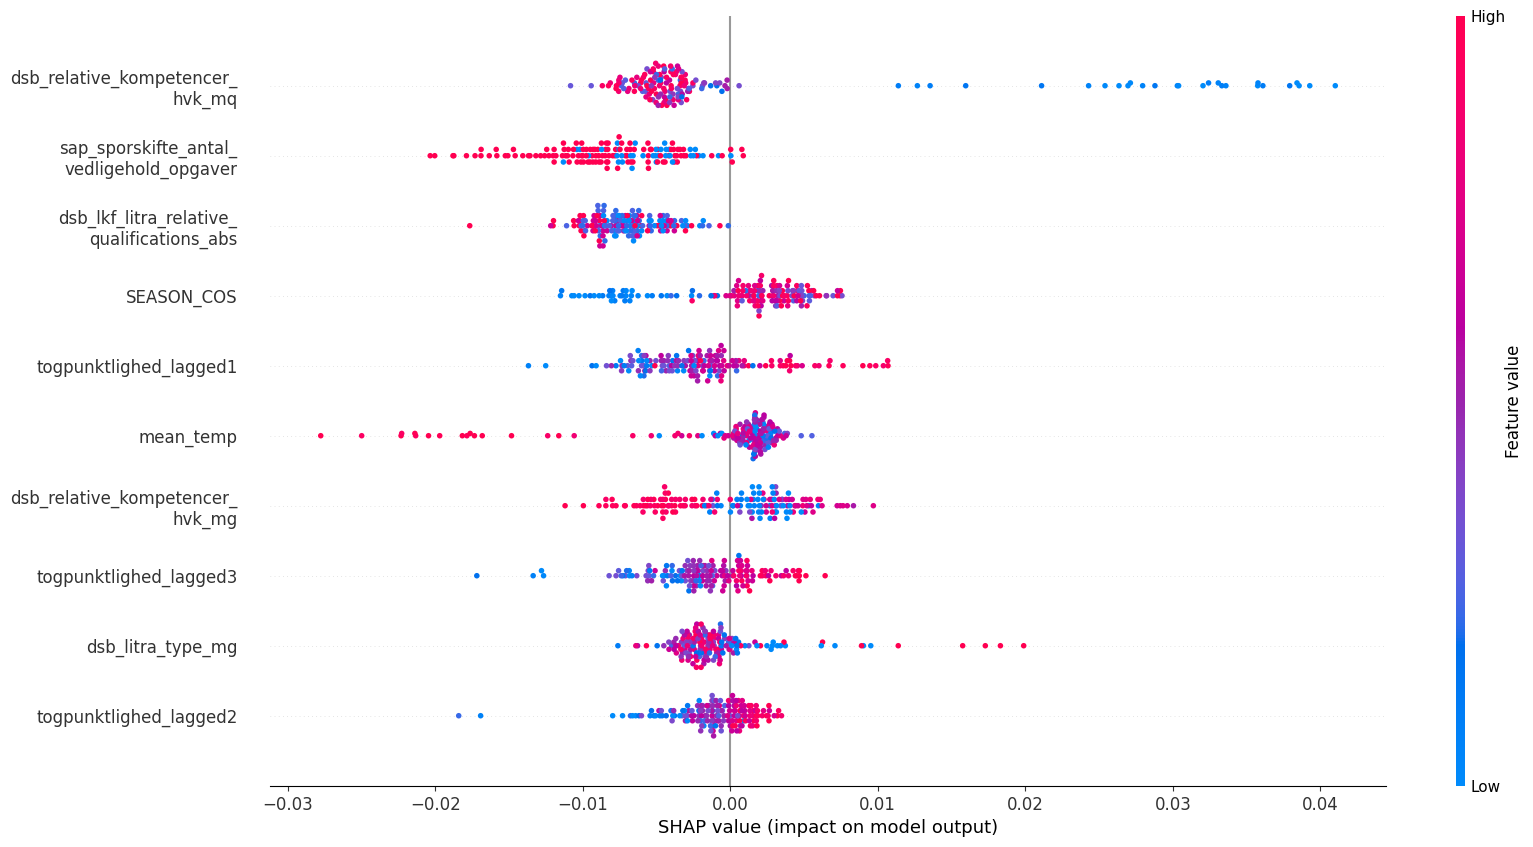

In [51]:
import matplotlib.pyplot as plt
import textwrap

shap.summary_plot(shap_matrix, X_used, show=False, max_display=10, plot_type='dot', plot_size=(0.1,16))
plt.gcf().set_size_inches(18, 10)
ax = plt.gca()
tick_labels = ax.get_yticklabels()
# Wrap long tick labels to the next line
max_chars_per_line = 23  # Define the maximum number of characters per line
wrapped_tick_labels = []
for label in tick_labels:
      text = label.get_text()
      # Find the nearest underscore within the specified range
      underscore_index = min(max_chars_per_line, len(text))  # Initialize with max_chars_per_line
      for i in range(max_chars_per_line - 5, len(text)):
            if text[i] == '_':
                  underscore_index = i
                  break
      wrapped_tick_labels.append(textwrap.fill(text, underscore_index+1))

# Set the wrapped tick labels
ax.set_yticklabels(wrapped_tick_labels)  # Ensure the number of labels matches the number of shap values


plt.yticks(fontsize = 12)
plt.xticks(fontsize=12)
plt.show()